In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install fredapi > /dev/null

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = '4e8e44dabaa81685455551d55e21d9c1'

# 1. Create the Fred object

In [4]:
fred = Fred(api_key = fred_key)

# 2. Search for Economic Data

In [5]:
sp_search = fred.search('S&P', order_by = 'popularity')

In [6]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-10-20,2023-10-20,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-10-19,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-10-20 09:25:09-05:00,93,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-10-20,2023-10-20,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2023-07-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-09-26 08:11:02-05:00,88,"For more information regarding the index, plea..."
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2023-10-20,2023-10-20,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-10-19,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-10-20 09:25:13-05:00,83,This data represents the effective yield of th...
SP500,SP500,2023-10-20,2023-10-20,S&P 500,2013-10-21,2023-10-19,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-10-19 19:11:01-05:00,82,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2023-10-20,2023-10-20,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2021 CPI-U-RS Adjusted Dollars,2021 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,81,Household data are collected as of March. As ...


# 3. Pull Raw Data and Plot!

In [7]:
sp500 = fred.get_series(series_id='SP500')

<Axes: title={'center': 'S&P 500'}>

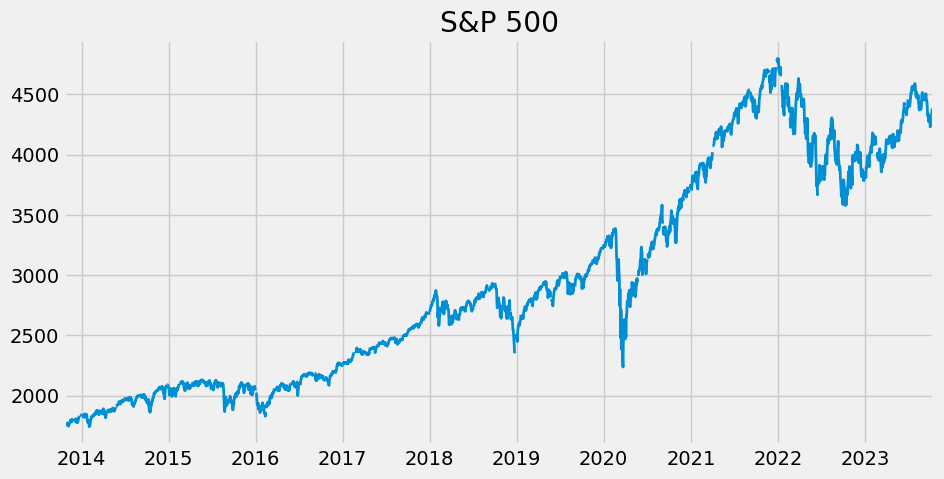

In [8]:
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)

# 4. Pull and Join Multiple Data Series

In [9]:
unemp_df = fred.search('unemployment rate state', filter=('frequency', 'Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [10]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
uemp_results = pd.concat(all_results, axis=1)

In [11]:
#uemp_states = uemp_results.drop('UNRATE', axis=1)
#uemp_states = uemp_states.dropna()
cols_to_drop = []

for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
        
uemp_states = uemp_results.drop(columns = cols_to_drop, axis=1)

id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [12]:
# Plot States' Unemployment Rate
px.line(uemp_states)

## Pull April 2020 Unemployment Rate Per State

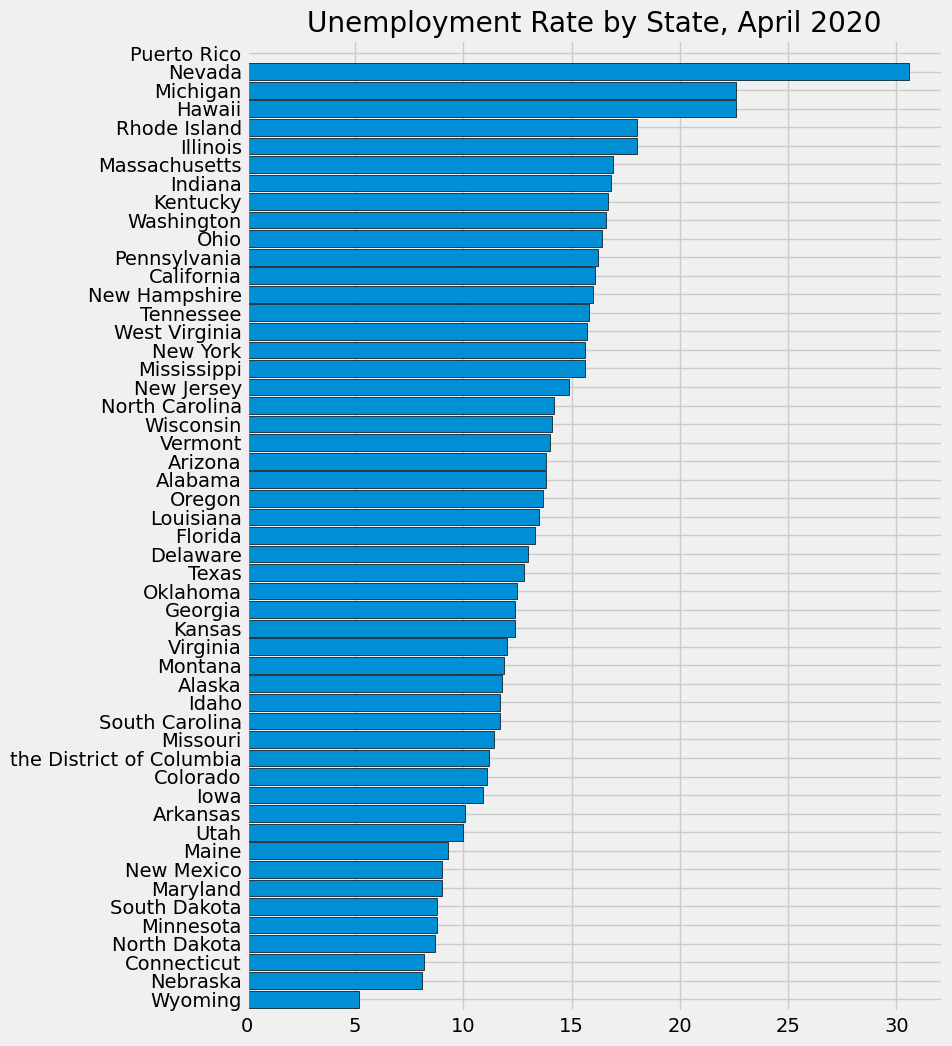

In [13]:
ax = uemp_states.loc[uemp_states.index == '2020-04-01'].T \
.sort_values('2020-04-1') \
.plot(kind='barh', figsize=(8, 12), width = 0.9, edgecolor = 'black', 
      title='Unemployment Rate by State, April 2020')
ax.legend().remove()
plt.show()

# Pull Participation Rate

In [14]:
part_df = fred.search('participation rate state', filter=('frequency', 'Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [15]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot New York Unemployment vs Participation

Text(0.5, 1.0, 'New York')

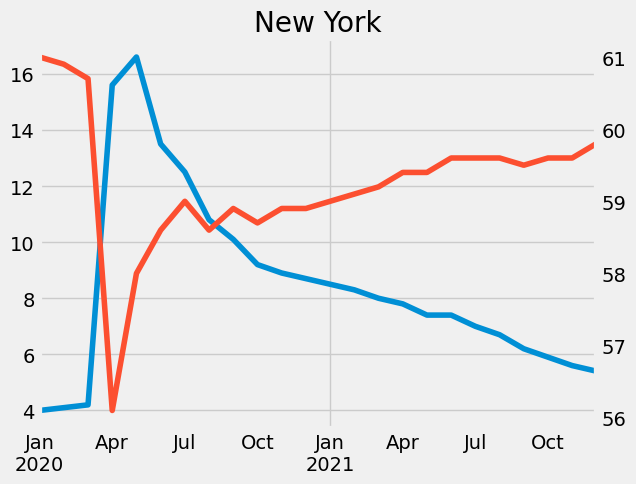

In [16]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
uemp_states.query('index >= 2020 and index < 2022')['New York'] \
    .plot(ax=ax, label = 'Unemployment')
part_states.query('index >= 2020 and index < 2022')['New York'] \
    .plot(ax=ax2, label = 'Participation', color = color_pal[1])
ax2.grid(False)
ax.set_title('New York')